In [1]:
# ==============================================================================
# 1. INSTALAÇÃO DE DEPENDÊNCIAS
# ==============================================================================
!pip install --upgrade pip -q
!pip install --upgrade \
    torch torchvision torchaudio \
    transformers datasets tokenizers accelerate \
    scikit-learn pandas tqdm google-colab \
    gdown pyarrow evaluate -q

print("✅ Dependências instaladas com sucesso!")

# ==============================================================================
# 2. IMPORTS CONSOLIDADOS
# ==============================================================================
import torch
import gdown
import zipfile
import gzip
import os
import shutil
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
from collections import Counter
import json
import evaluate

# Hugging Face
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import Dataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Google Colab
from google.colab import drive

# ==============================================================================
# 3. CONEXÃO COM GOOGLE DRIVE
# ==============================================================================
# Conecta ao GoogleDrive para salvar os resultados e modelos.
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 78.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
✅ Dependências instaladas com sucesso!
Mounted at /content/drive


In [7]:
# ==============================================================================
# 4. CONFIGURAÇÕES GLOBAIS E HIPERPARÂMETROS (AJUSTADO PARA BERT)
# ==============================================================================
# --- Configurações de Caminhos ---
DATA_DIR = "/content/drive/MyDrive/tech_challenge"
DRIVE_JSON_PATH = f"{DATA_DIR}/trn.json"
LOCAL_JSON_PATH = "./amazon_titles/LF-Amazon-1.3M/trn.json"
OUTPUT_DIR = "bert_amz_titles" # <-- MUDANÇA: Novo diretório de saída
CACHE_DIR = "./cache"

# --- Hiperparâmetros do Modelo e Treinamento ---
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 64
MAX_LENGTH = 384
EPOCHS = 10
LR = 3e-5
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
GRAD_ACC = 1
FP16 = torch.cuda.is_available() # Ativa FP16 apenas se a GPU estiver disponível
GRAD_CHECKPOINT = True
WORKERS = 6                      # Número de workers para o dataloader
VALIDATION_SPLIT = 0.2           # Usaremos uma divisão fixa de 20% para validação
RANDOM_SEED = 42

# --- Controle de Semente para Reprodutibilidade ---
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

In [8]:
# ==============================================================================
# 5. FUNÇÕES AUXILIARES PARA DOWNLOAD E CARREGAMENTO
# ==============================================================================

def download_extract_file(extract_dir):
    file_id = "12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK"
    output = "amazon_titles.zip"
    print(f"📥 Iniciando download de {output}...")
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ ZIP descompactado em {extract_dir}")

    gz_path = os.path.join(extract_dir, "LF-Amazon-1.3M", "trn.json.gz")
    json_path = os.path.join(extract_dir, "LF-Amazon-1.3M", "trn.json")

    with gzip.open(gz_path, 'rt', encoding='utf-8') as f_in:
        with open(json_path, 'w', encoding='utf-8') as f_out:
            f_out.write(f_in.read())
    print(f"✅ trn.json.gz descompactado para {json_path}")
    return json_path

def get_dataset_file(local_path, drive_path):
    if os.path.isfile(local_path):
        print(f"✅ Arquivo já existe localmente: {local_path}")
        return local_path

    folder = Path(local_path).parent
    folder.mkdir(parents=True, exist_ok=True)

    if os.path.ismount("/content/drive"):
        print("📂 Google Drive está montado.")
        if os.path.isfile(drive_path):
            print("📥 Copiando arquivo do Drive para o ambiente local...")
            shutil.copy(drive_path, local_path)
            print(f"✅ Copiado para {local_path}")
            return local_path
        else:
            print("❌ Arquivo não encontrado no Google Drive. Iniciando download.")
    else:
        print("❌ Google Drive não está montado. Iniciando download.")

    return download_extract_file(folder)

def load_amazontitles_json(path):
    data = []
    short_texts = 0

    def clean_html_tags(text):
        clean = re.compile('<.*?>')
        return re.sub(clean, '', text)

    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Lendo arquivo JSON bruto"):
            d = json.loads(line)
            if all(field in d for field in ["uid", "title", "content", "target_ind"]):
                title = (d["title"] or "").strip()
                content = (d["content"] or "").strip()
                target_ind = d["target_ind"]
                if not title or not content or not isinstance(target_ind, list) or len(target_ind) == 0:
                    continue
                label = target_ind[0]
                combined_text = clean_html_tags(title) + " [SEP] " + clean_html_tags(content)
                if len(combined_text.split()) < 5:
                    short_texts += 1
                    continue
                data.append({"text": combined_text, "raw_label": label})

    if short_texts > 0:
        print(f"Descartados {short_texts} exemplos por textos muito curtos.")

    return pd.DataFrame(data)

In [9]:
# ==============================================================================
# 6. PIPELINE PRINCIPAL DE CARREGAMENTO E PRÉ-PROCESSAMENTO
# ==============================================================================
from datasets import ClassLabel # <-- ADICIONE ESTE IMPORT

# Garante que o arquivo de dados esteja disponível localmente
local_file_path = get_dataset_file(LOCAL_JSON_PATH, DRIVE_JSON_PATH)

print("\nCarregando e processando dados...")
df = load_amazontitles_json(local_file_path)

# Amostra de 50.000 exemplos para um treinamento mais rápido (ajuste se necessário)
print(f"Usando uma amostra de 100.000 exemplos do total de {len(df)}.")
df_filtered = df.sample(n=100000, random_state=RANDOM_SEED).dropna().reset_index(drop=True)

# Lógica de agrupamento de labels (binning)
num_general_classes = 25
labels_sampled = df_filtered['raw_label'].tolist()
min_label, max_label = min(labels_sampled), max(labels_sampled)
df_filtered = df_filtered[(df_filtered['raw_label'] >= min_label) & (df_filtered['raw_label'] <= max_label)].copy()
df_filtered['binned_label'] = pd.cut(df_filtered['raw_label'], bins=num_general_classes, labels=False, include_lowest=True)
label_counts = df_filtered['binned_label'].value_counts()
rare_labels = label_counts[label_counts == 1].index
df_filtered = df_filtered[~df_filtered['binned_label'].isin(rare_labels)]
unique_labels = sorted(df_filtered['binned_label'].unique())
label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
df_filtered['label'] = df_filtered['binned_label'].map(label_map)
n_classes = df_filtered['label'].nunique()

print(f"Agrupados {len(set(labels_sampled))} labels originais em {n_classes} classes gerais.")
print("\nDistribuição das classes no dataset filtrado:")
print(df_filtered['label'].value_counts().sort_index())

# Converte o DataFrame para o formato da biblioteca `datasets`
hf_dataset = Dataset.from_pandas(df_filtered[['text', 'label']])

# ==============================================================================
# CORREÇÃO APLICADA AQUI!
# Converte a coluna 'label' para o tipo ClassLabel para permitir a estratificação.
# ==============================================================================
hf_dataset = hf_dataset.cast_column("label", ClassLabel(num_classes=n_classes))

✅ Arquivo já existe localmente: ./amazon_titles/LF-Amazon-1.3M/trn.json

Carregando e processando dados...


Lendo arquivo JSON bruto: 0it [00:00, ?it/s]

Descartados 760 exemplos por textos muito curtos.
Usando uma amostra de 100.000 exemplos do total de 1389643.
Agrupados 49688 labels originais em 25 classes gerais.

Distribuição das classes no dataset filtrado:
label
0     32648
1      9389
2      9253
3      5587
4      3500
5      5151
6      3533
7      4518
8      3756
9      3096
10     3721
11     4054
12      852
13     1962
14     1432
15     1368
16     1021
17      867
18      792
19      734
20      664
21      620
22      692
23      525
24      265
Name: count, dtype: int64


Casting the dataset:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [35]:
# ==============================================================================
# 6. PIPELINE DE CARREGAMENTO E PRÉ-PROCESSAMENTO (COM AGRUPAMENTO DE CLASSES)
# ==============================================================================
from datasets import ClassLabel

# Garante que o arquivo de dados esteja disponível localmente
local_file_path = get_dataset_file(LOCAL_JSON_PATH, DRIVE_JSON_PATH)

print("\nCarregando e processando dados...")
df = load_amazontitles_json(local_file_path)

# Amostra de 50.000 exemplos
print(f"Usando uma amostra de 500.000 exemplos do total de {len(df)}.")
df_filtered = df.sample(n=500000, random_state=RANDOM_SEED).dropna().reset_index(drop=True)

# Lógica de agrupamento de labels (binning) original
# (Esta parte continua igual)
num_general_classes = 25
labels_sampled = df_filtered['raw_label'].tolist()
min_label, max_label = min(labels_sampled), max(labels_sampled)
df_filtered = df_filtered[(df_filtered['raw_label'] >= min_label) & (df_filtered['raw_label'] <= max_label)].copy()
df_filtered['binned_label'] = pd.cut(df_filtered['raw_label'], bins=num_general_classes, labels=False, include_lowest=True)
label_counts = df_filtered['binned_label'].value_counts()
rare_labels = label_counts[label_counts == 1].index
df_filtered = df_filtered[~df_filtered['binned_label'].isin(rare_labels)]
unique_labels_binned = sorted(df_filtered['binned_label'].unique())
label_map_binned = {old_label: new_label for new_label, old_label in enumerate(unique_labels_binned)}
df_filtered['label'] = df_filtered['binned_label'].map(label_map_binned)

print(f"Agrupados {len(set(labels_sampled))} labels originais em {df_filtered['label'].nunique()} classes gerais.")
print("\nDistribuição ANTES do agrupamento de classes raras:")
print(df_filtered['label'].value_counts().sort_index())


# ==============================================================================
# NOVA LÓGICA: AGRUPAMENTO DE CLASSES RARAS EM "OUTROS"
# ==============================================================================
print("\nIniciando o agrupamento de classes raras...")
LIMIAR_CLASSE_RARA = 300 # Define que qualquer classe com menos de 300 exemplos é "rara"

class_counts = df_filtered['label'].value_counts()
classes_comuns = class_counts[class_counts >= LIMIAR_CLASSE_RARA].index.tolist()
classes_raras = class_counts[class_counts < LIMIAR_CLASSE_RARA].index.tolist()

# Mantém apenas as classes comuns e cria uma cópia para evitar warnings
df_agrupado = df_filtered[df_filtered['label'].isin(classes_comuns)].copy()

# Cria um dataframe com as classes raras e atribui a elas um novo label "Outros"
if classes_raras:
    label_outros = len(classes_comuns) # O novo label será o próximo número disponível
    df_raras = df_filtered[df_filtered['label'].isin(classes_raras)].copy()
    df_raras['label'] = label_outros
    # Combina os dataframes
    df_final = pd.concat([df_agrupado, df_raras], ignore_index=True)
    print(f"{len(classes_raras)} classes raras foram agrupadas na nova classe 'Outros' (label {label_outros}).")
else:
    df_final = df_agrupado
    print("Nenhuma classe rara encontrada para agrupar.")


# Remapeia todos os labels para serem contínuos (0, 1, 2, ...)
# Isso é importante para o modelo
unique_labels_final = sorted(df_final['label'].unique())
final_label_map = {old_label: new_label for new_label, old_label in enumerate(unique_labels_final)}
df_final['label'] = df_final['label'].map(final_label_map)

# Atualiza a contagem final de classes
n_classes = df_final['label'].nunique()
print(f"\nO problema foi simplificado para {n_classes} classes no total.")

print("\nDistribuição FINAL das classes (após agrupamento):")
print(df_final['label'].value_counts().sort_index())

# Converte para o formato da biblioteca `datasets`
hf_dataset = Dataset.from_pandas(df_final[['text', 'label']])

# Converte a coluna 'label' para o tipo ClassLabel para permitir a estratificação
hf_dataset = hf_dataset.cast_column("label", ClassLabel(num_classes=n_classes))

# ** IMPORTANTE: A variável df_filtered será substituída pela nova, que contém os dados agrupados **
df_filtered = df_final

✅ Arquivo já existe localmente: ./amazon_titles/LF-Amazon-1.3M/trn.json

Carregando e processando dados...


Lendo arquivo JSON bruto: 0it [00:00, ?it/s]

Descartados 760 exemplos por textos muito curtos.
Usando uma amostra de 500.000 exemplos do total de 1389643.
Agrupados 145186 labels originais em 25 classes gerais.

Distribuição ANTES do agrupamento de classes raras:
label
0     163273
1      46730
2      46143
3      27874
4      17465
5      26147
6      17739
7      22711
8      18479
9      15488
10     19235
11     19773
12      4443
13     10205
14      7239
15      6679
16      5151
17      4326
18      3860
19      3696
20      3224
21      2990
22      3426
23      2486
24      1218
Name: count, dtype: int64

Iniciando o agrupamento de classes raras...
Nenhuma classe rara encontrada para agrupar.

O problema foi simplificado para 25 classes no total.

Distribuição FINAL das classes (após agrupamento):
label
0     163273
1      46730
2      46143
3      27874
4      17465
5      26147
6      17739
7      22711
8      18479
9      15488
10     19235
11     19773
12      4443
13     10205
14      7239
15      6679
16      5151


Casting the dataset:   0%|          | 0/500000 [00:00<?, ? examples/s]

In [36]:
# ==============================================================================
# 7. TOKENIZAÇÃO E PREPARAÇÃO FINAL DO DATASET
# ==============================================================================
print("\nInicializando o tokenizador...")
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    """Função para tokenizar um lote de textos."""
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

print("Aplicando tokenização ao dataset (pode levar alguns minutos)...")
# O método .map é altamente otimizado e processa os dados em lote
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)

print(f"\nDividindo os dados em {1-VALIDATION_SPLIT:.0%} para treino e {VALIDATION_SPLIT:.0%} para validação...")
split_dataset = tokenized_dataset.train_test_split(
    test_size=VALIDATION_SPLIT,
    stratify_by_column='label',
    seed=RANDOM_SEED
)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

print(f"Tamanho final -> Treino: {len(train_dataset)}, Validação: {len(val_dataset)}")


Inicializando o tokenizador...
Aplicando tokenização ao dataset (pode levar alguns minutos)...


Map:   0%|          | 0/500000 [00:00<?, ? examples/s]


Dividindo os dados em 80% para treino e 20% para validação...
Tamanho final -> Treino: 400000, Validação: 100000


In [37]:
# ==============================================================================
# 8. TREINAMENTO DO MODELO COM BERT E BALANCEAMENTO DE CLASSES
# ==============================================================================
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score # Import accuracy_score and f1_score
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
# MUDANÇA: Importando as classes automáticas para maior flexibilidade
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments # Import Trainer and TrainingArguments
from transformers.trainer_callback import EarlyStoppingCallback # Import EarlyStoppingCallback
from datasets import Dataset # Import Dataset, although it's not strictly needed here because it's imported before.

# --- Define device (GPU or CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


# --- 1. Calcular os Pesos das Classes ---
train_labels = np.array(train_dataset['label'])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Pesos calculados para as {n_classes} classes.")

# --- 2. Criar um Trainer Customizado para Usar os Pesos ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- 3. Inicializar e Treinar o Modelo ---
print("\nInstanciando modelo BERT...")
# MUDANÇA: Usando a classe AutoModel...
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=n_classes,
    cache_dir=CACHE_DIR
)
# MUDANÇA: O tokenizer também usa a classe AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Move o modelo para o dispositivo
model.to(device)


if GRAD_CHECKPOINT:
    model.gradient_checkpointing_enable()

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=1)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Argumentos de Treinamento
training_args = TrainingArguments(output_dir=OUTPUT_DIR, per_device_train_batch_size=BATCH_SIZE, per_device_eval_batch_size=BATCH_SIZE,
                                  gradient_accumulation_steps=GRAD_ACC, learning_rate=LR, num_train_epochs=EPOCHS, weight_decay=WEIGHT_DECAY,
                                  warmup_steps=WARMUP_STEPS, eval_strategy="steps", eval_steps=100, save_steps=100, logging_steps=25,
                                  save_total_limit=2, fp16=FP16, dataloader_num_workers=WORKERS, dataloader_pin_memory=True,
                                  load_best_model_at_end=True, metric_for_best_model="eval_loss", greater_is_better=False,
                                  gradient_checkpointing=GRAD_CHECKPOINT, report_to="none")

trainer = WeightedTrainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset,
                          compute_metrics=compute_metrics, callbacks=[EarlyStoppingCallback(early_stopping_patience=5)])

print("\n🚀 Iniciando o treinamento com balanceamento de classes...")
trainer.train()

print("\n✅ Treinamento concluído! Salvando o melhor modelo...")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Modelo e tokenizador salvos em '{OUTPUT_DIR}'.")

Usando dispositivo: cuda
Pesos calculados para as 25 classes.

Instanciando modelo BERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Iniciando o treinamento com balanceamento de classes...


Step,Training Loss,Validation Loss,Accuracy,F1
100,3.219700,3.214057,0.320950,0.176022
200,3.159500,3.147453,0.264230,0.241127
300,3.008800,3.012357,0.251810,0.230477
400,2.990400,2.943461,0.245590,0.245176
500,2.902200,2.903626,0.258920,0.257986
600,2.868500,2.879039,0.249120,0.260633
700,2.873800,2.855238,0.276010,0.275280
800,2.913600,2.853648,0.264940,0.270657
900,2.853100,2.847022,0.254170,0.260661
1000,2.857900,2.823438,0.274380,0.276583



✅ Treinamento concluído! Salvando o melhor modelo...
Modelo e tokenizador salvos em 'bert_amz_titles'.



📊 Executando avaliação final no conjunto de validação...



Resultados das Métricas Finais:
- eval_loss: 2.6023
- eval_accuracy: 0.3217
- eval_f1: 0.3424
- eval_runtime: 34.9994
- eval_samples_per_second: 2857.1930
- eval_steps_per_second: 44.6580
- epoch: 1.4400

🔎 Gerando previsões para análise detalhada...

📊 Relatório de Classificação (por classe):
              precision    recall  f1-score   support

    Classe 0      0.740     0.572     0.645     32655
    Classe 1      0.243     0.238     0.240      9346
    Classe 2      0.305     0.164     0.214      9228
    Classe 3      0.316     0.253     0.281      5575
    Classe 4      0.174     0.204     0.188      3493
    Classe 5      0.259     0.150     0.190      5229
    Classe 6      0.124     0.236     0.163      3548
    Classe 7      0.193     0.121     0.149      4542
    Classe 8      0.171     0.214     0.190      3696
    Classe 9      0.241     0.174     0.202      3098
   Classe 10      0.323     0.074     0.120      3847
   Classe 11      0.388     0.198     0.262      3955
 

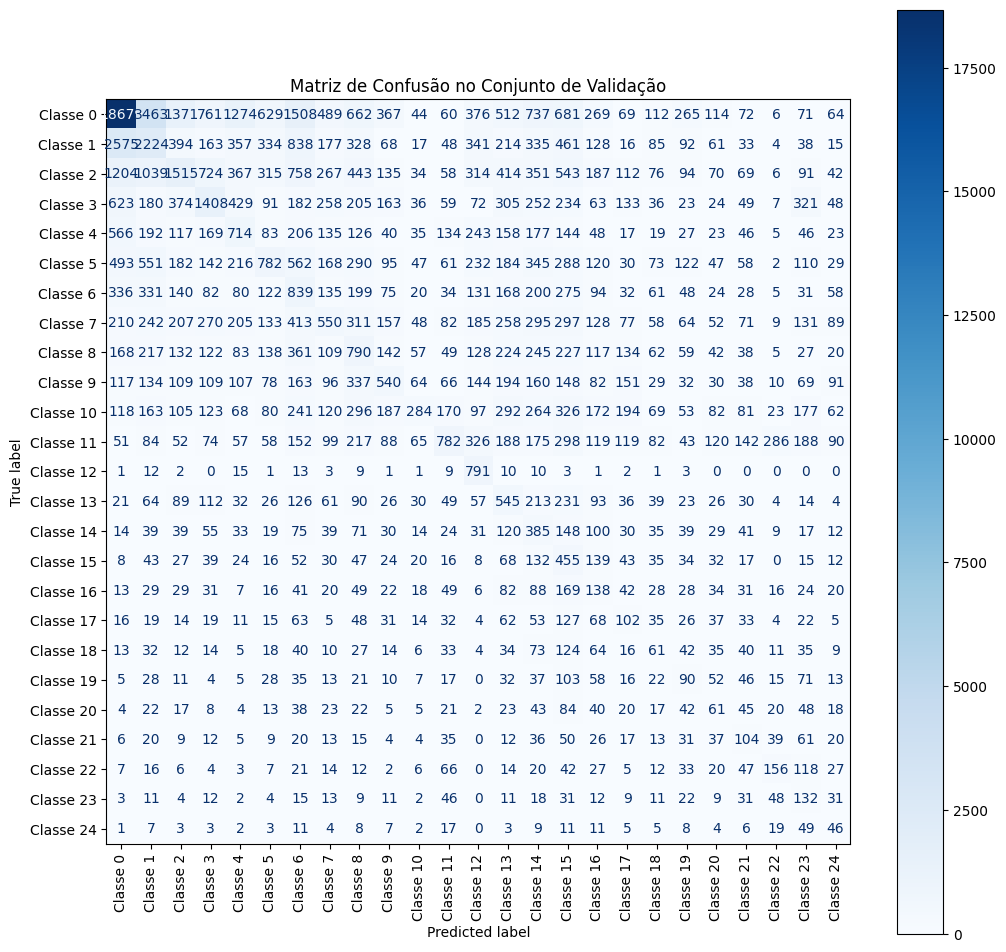

In [38]:
# ==============================================================================
# 9. AVALIAÇÃO FINAL DETALHADA
# ==============================================================================
print("\n📊 Executando avaliação final no conjunto de validação...")
eval_results = trainer.evaluate()
print("\nResultados das Métricas Finais:")
for key, value in eval_results.items():
    print(f"- {key}: {value:.4f}")

print("\n🔎 Gerando previsões para análise detalhada...")
predictions = trainer.predict(val_dataset)

y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

# Gera nomes de classes para os relatórios
target_names = [f'Classe {i}' for i in range(n_classes)]

# --- Relatório de Classificação ---
print("\n📊 Relatório de Classificação (por classe):")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

# --- Matriz de Confusão ---
print("\n📊 Matriz de Confusão:")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

# Plotagem da matriz com tamanho ajustado
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap="Blues", xticks_rotation=90, values_format="d", ax=ax)
plt.title("Matriz de Confusão no Conjunto de Validação")
plt.show()

# --- Histórico de Logs (Opcional) ---
# print("\n📜 Histórico completo de logs do treinamento:")
# print(trainer.state.log_history)

In [39]:
# ==============================================================================
# 10. TESTE COM UMA NOVA PERGUNTA (CORRIGIDO COM AUTO CLASSES)
# ==============================================================================
import torch
# MUDANÇA: Usando AutoTokenizer e AutoModelForSequenceClassification para carregar qualquer modelo
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- Defina sua pergunta de teste aqui ---
pergunta_teste = "4k monitor for gaming with high refresh rate"

# --- Mapeamento de ID para Label (para legibilidade da resposta) ---
id2label = {i: f"Classe Prevista {i}" for i in range(n_classes)}

# --- Verificação de dispositivo (GPU ou CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# ==============================================================================
# Resposta 1: Modelo SEM Treinamento (BERT base)
# ==============================================================================
print("\n" + "="*50)
print("🔎 1. PREVISÃO COM O MODELO ORIGINAL (SEM TREINAMENTO)")
print("="*50)

# Carrega o modelo e tokenizador originais da Hugging Face usando as classes Auto
tokenizer_base = AutoTokenizer.from_pretrained(MODEL_NAME)
model_base = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=n_classes)
model_base.to(device)

# Prepara a pergunta
inputs_base = tokenizer_base(pergunta_teste, return_tensors="pt").to(device)

# Realiza a previsão
with torch.no_grad():
    logits_base = model_base(**inputs_base).logits

previsao_id_base = logits_base.argmax().item()
previsao_label_base = id2label[previsao_id_base]

print(f"Texto da Pergunta: '{pergunta_teste}'")
print(f"➡️ Resposta do Modelo SEM Treinamento: {previsao_label_base} (ID: {previsao_id_base})\n")


# ==============================================================================
# Resposta 2: Modelo COM Treinamento (Carregado do seu diretório)
# ==============================================================================
print("\n" + "="*50)
print("🚀 2. PREVISÃO COM O SEU MODELO TREINADO")
print("="*50)

# MUDANÇA: Carrega o SEU modelo e tokenizador salvos usando as classes Auto
tokenizer_treinado = AutoTokenizer.from_pretrained(OUTPUT_DIR)
model_treinado = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR)
model_treinado.to(device)

# Prepara a mesma pergunta
inputs_treinado = tokenizer_treinado(pergunta_teste, return_tensors="pt").to(device)

# Realiza a previsão
with torch.no_grad():
    logits_treinado = model_treinado(**inputs_treinado).logits

previsao_id_treinado = logits_treinado.argmax().item()
previsao_label_treinado = id2label[previsao_id_treinado]

print(f"Texto da Pergunta: '{pergunta_teste}'")
print(f"➡️ Resposta do Modelo COM Treinamento: {previsao_label_treinado} (ID: {previsao_id_treinado})")

Usando dispositivo: cuda

🔎 1. PREVISÃO COM O MODELO ORIGINAL (SEM TREINAMENTO)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Texto da Pergunta: '4k monitor for gaming with high refresh rate'
➡️ Resposta do Modelo SEM Treinamento: Classe Prevista 18 (ID: 18)


🚀 2. PREVISÃO COM O SEU MODELO TREINADO
Texto da Pergunta: '4k monitor for gaming with high refresh rate'
➡️ Resposta do Modelo COM Treinamento: Classe Prevista 3 (ID: 3)
